Epoch 1/100
852/852 [==============================] - 14s 15ms/step - loss: 3455.6506 - val_loss: 0.0193
Epoch 2/100
852/852 [==============================] - 16s 19ms/step - loss: 0.0459 - val_loss: 0.0193
Epoch 3/100
852/852 [==============================] - 13s 15ms/step - loss: 0.0457 - val_loss: 0.0189
Epoch 4/100
852/852 [==============================] - 12s 14ms/step - loss: 0.0457 - val_loss: 0.0190
Epoch 5/100
852/852 [==============================] - 12s 15ms/step - loss: 0.0459 - val_loss: 0.0187
Epoch 6/100
852/852 [==============================] - 12s 14ms/step - loss: 0.0460 - val_loss: 0.0245
Epoch 7/100
852/852 [==============================] - 12s 14ms/step - loss: 0.0468 - val_loss: 0.0193
Epoch 8/100
852/852 [==============================] - 12s 14ms/step - loss: 0.0473 - val_loss: 0.3851
Epoch 9/100
852/852 [==============================] - 12s 14ms/step - loss: 0.0517 - val_loss: 5.0564
Epoch 10/100
852/852 [==============================] - 14s 17ms/step 

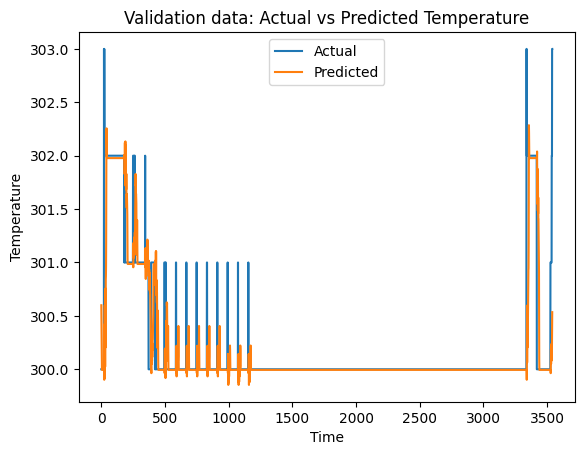

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from datetime import datetime

# Function to load data from CSV files with time information in seconds
def load_data_with_time(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            time_seconds = int(filename.split('_')[0])  # Extract time from filename
            time = datetime.fromtimestamp(time_seconds)
            df = pd.read_csv(filepath)
            # Handle missing values by filling them with the mean of the column
            df.fillna(df.mean(), inplace=True)
            df['Time'] = time  # Add time column to dataframe
            data.append(df)
    return pd.concat(data, ignore_index=True)

# Function to convert time series data into samples for Convolutional LSTM
def create_samples(data, lookback):
    X, y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data['total-temperature'].iloc[i:i+lookback])
        y.append(data['total-temperature'].iloc[i+lookback+1])
    return np.array(X), np.array(y)

# Load data from directory with time information
train_data_directory = "/content/Data"
train_raw_data = load_data_with_time(train_data_directory)

# Define parameters
lookback = 19  # Number of time steps to look back
n_features = 1  # Number of features (temperature in this case)

# Prepare data
X_train, y_train = create_samples(train_raw_data, lookback)

# Reshape data for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Build the Convolutional LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Load validation data from a different directory
val_data_directory = "/content/Val_data"
val_raw_data = load_data_with_time(val_data_directory)

# Prepare validation data
X_val, y_val = create_samples(val_raw_data, lookback)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

# Make predictions for validation data
y_pred_val = model.predict(X_val)

# Plot actual vs predicted values for validation data
plt.plot(y_val, label='Actual')
plt.plot(y_pred_val, label='Predicted')
plt.legend()
plt.title('Validation data: Actual vs Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [ ]:
print(y_pred_val_2d.shape)


(3541, 1)


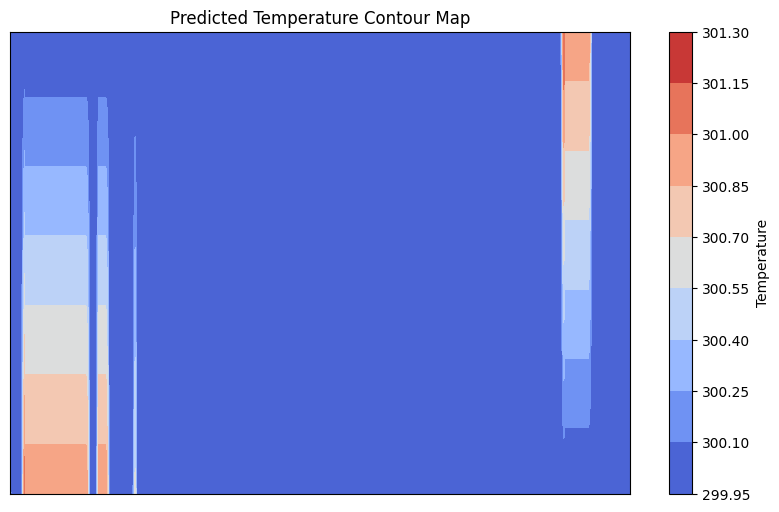

In [ ]:
# Create contour plot without labels
plt.figure(figsize=(10, 6))
contour = plt.contourf(time_steps, temperature_values, y_pred_val_2d, cmap='coolwarm')
plt.colorbar(contour, label='Temperature')
plt.title('Predicted Temperature Contour Map')
plt.show()